In [55]:
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
#%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (5,3)

def reduceMapping(x):
    x = x.strip('[]').strip("''")
    x = x.split(',')
    return str(x[0])

def removeNumberOMS(x):
    x = re.sub("^\d*_","",x)
    return x 

def countMissing(x):
    x = x.isnull().sum()
    print(x)
    return x
   
def countNAN(df, n_samples, name):
    occ = []
    for i in range(len(df.index)): 
        occ.append(n_samples-(df.iloc[i].isnull().sum()))
    df[name] = occ
    return df
    
def createMapping_mdia(mapping_df, path, n_samples, name):
    df = pd.read_csv(path, sep = '\t')
    df_map = pd.merge(mapping_df, df, left_on='mdia_formula', right_on='Protein')
    df_map.replace(0.0, np.nan, inplace=True)
    df_map = countNAN(df_map, n_samples, name)
    return df_map

def createMapping_oms(mapping_df, path, n_samples, name, from_mdia):
    df = pd.read_csv(path, sep = '\t')
    df['Protein'] = df['Protein'].apply(removeNumberOMS)
    if from_mdia:
        df_map = pd.merge(mapping_df, df, left_on='mdia_formula', right_on='Protein')
    else: 
        df_map = pd.merge(mapping_df, df, left_on='oms_formula', right_on='Protein')
    df_map.replace(0.0, np.nan, inplace=True)
    df_map = countNAN(df_map, n_samples, name)
    return df_map
    
def createComparison(map_a, map_b, compare_on, col_a, col_b, how):
    merge = pd.merge(map_a, map_b, on=compare_on, how=how) #mdia_formula
    #merge.to_csv("~/Desktop/test_compare_oms_oms_py.csv", index = False)
    merge_small = merge[[compare_on, col_a, col_b]] # 'oms_occ', 'mdia_occ'

    col_a_value_count = merge_small[col_a].value_counts()
    col_b_value_count = merge_small[col_b].value_counts()

    feature_list = ['f', col_a, col_b]
    compare = pd.DataFrame(0, index=np.arange(n_samples), columns=feature_list)

    compare['f'] = list(range(1, int(n_samples)+1))
    compare_np = compare.to_numpy()

    for data in col_a_value_count.items():
        int_data = int(data[0])
        compare_np.itemset((int_data-1,1), data[1])
    for data in col_b_value_count.items():
        int_data = int(data[0])
        compare_np.itemset((int_data-1,2),data[1])

    compare = pd.DataFrame(data=compare_np, columns=['f', col_a, col_b])
    return compare
     

In [56]:
mapping_path = "/Volumes/elements/MetaboDIA/comparison/mapping_from_library/mdia_02_oms_mt1_02_uk_67.tsv"
mdia_path = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/mdia_10ppm_25ppm_min_spec_02_pf00/protein_level_mdia_10ppm_25ppm_min_spec_02_pf00.txt"
mdia_oms = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/oms_mdia_10ppm_25ppm_min_spec_02_pf00/20201205_oms_mdia_10ppm_25ppm_min_spec_02_pf00_DIAlignR_std_linear_mapping.tsv"
##add mdia_oms_py
oms_path = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/s45_mt1_resolve_totoc_02_67/20201214_s45_mt1_resolve_totoc_02_67_DIAlignR_std_linear_mapping.tsv"
oms_py_path = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/S45_mt1_resolve_totoc_02_67_pyprophet/20201215_s45_mt1_resolve_totoc_67_02_pyprophet_mapping.tsv"

n_samples = 60

mapping_df = pd.read_csv(mapping_path, sep = '\t')
mapping_df['oms_formula'] = mapping_df['oms_formula'].apply(reduceMapping)
mapping_df.to_csv("~/Desktop/test_mapping.csv", index = False)

mdia_map = createMapping_mdia(mapping_df, mdia_path, n_samples, 'mdia_occ')
oms_map = createMapping_oms(mapping_df, oms_path, n_samples, 'oms_occ', False)
oms_py_map = createMapping_oms(mapping_df, oms_py_path, n_samples, 'oms_py_occ', False)
mdia_oms_map = createMapping_oms(mapping_df, mdia_oms, n_samples, 'mdia_oms_occ', True)

## Find the optimal merging, since inner will duplicate some of the entries, since 
## there are multiple molformula with different retention times in the OMS resutls!! 

compare_mdia_oms = createComparison(oms_map, mdia_map, 'mdia_formula', 'oms_occ', 'mdia_occ', 'inner')
compare_mdia_oms_oms = createComparison(oms_map, mdia_oms_map, 'mdia_formula', 'oms_occ', 'mdia_oms_occ', 'inner')
compare_oms_oms_py = createComparison(oms_map, oms_py_map,'oms_formula', 'oms_occ', 'oms_py_occ', 'inner')

# Binning for plotting

bins = [0,10,20,30,40,50,60]
columns = ["bin", "oms_occ", "mdia_occ"]
oms_list = []
mdia_list = []

for i in range(0,len(bins)-1):   
    df = compare_mdia_oms[bins[i]+1:bins[i+1]]
    df_agg = df.agg(sum)
    oms_list.append(df_agg['oms_occ'])
    mdia_list.append(df_agg['mdia_occ'])

index = [10,20,30,40,50,60]
binned_df = pd.DataFrame(
    {'BIN': index,
     'DIAMetAlyzer': oms_list,
     'MetaboDIA': mdia_list
    })

print(binned_df)

   BIN  DIAMetAlyzer  MetaboDIA
0   10             0          0
1   20             0         16
2   30             0          8
3   40             1          2
4   50             0          8
5   60            40          5


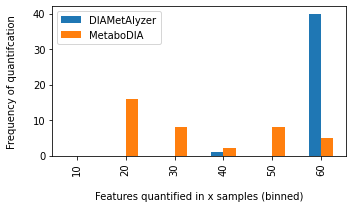

In [58]:
plot = binned_df.plot(x="BIN", y=["DIAMetAlyzer", "MetaboDIA"], kind="bar")
plot.set_ylabel("Frequency of quantifcation\n")
plot.set_xlabel("\nFeatures quantified in x samples (binned)")
plt.tight_layout()
plt.savefig('/Users/alka/Desktop/quant_oms_mdia_binned_nonscaled.svg')

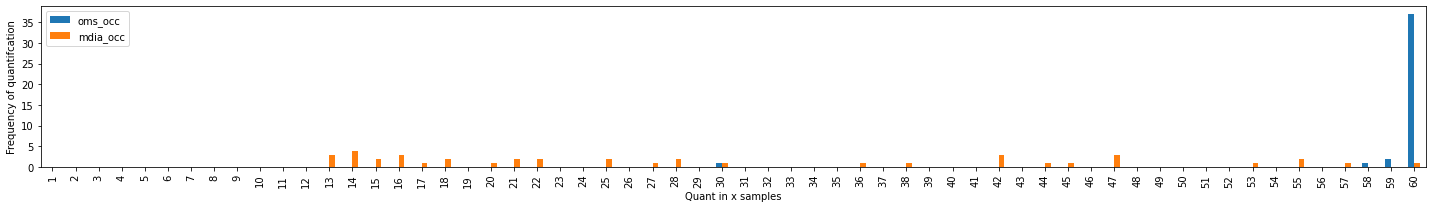

In [7]:
plot = compare_mdia_oms.plot(x="f", y=["oms_occ", "mdia_occ"], kind="bar")
plot.set_ylabel("Frequency of quantifcation")
plot.set_xlabel("Quantified in n samples")
plt.tight_layout()
plt.savefig('/Users/alka/Desktop/quant_oms_mdia.svg')


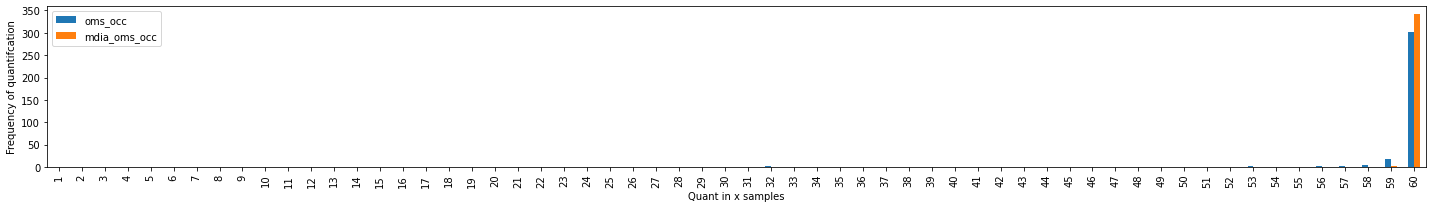

In [4]:
plot = compare_mdia_oms_oms.plot(x="f", y=["oms_occ", "mdia_oms_occ"], kind="bar")
plot.set_ylabel("Frequency of quantifcation")
plot.set_xlabel("Quant in x samples")
plt.tight_layout()
plt.savefig('/Users/alka/Desktop/quant_mdia_oms_oms.svg')


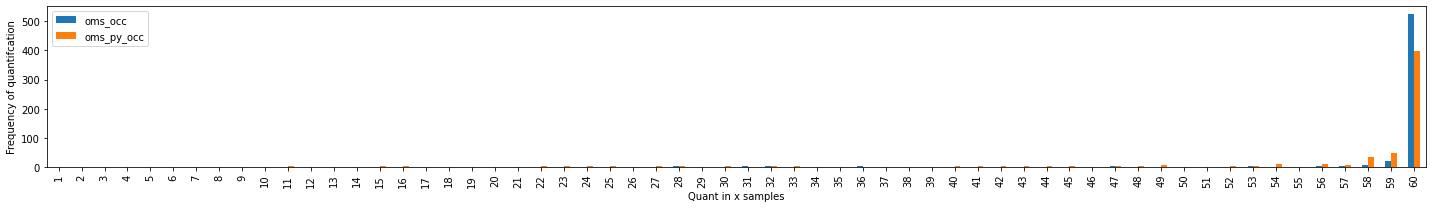

In [5]:
plot = compare_oms_oms_py.plot(x="f", y=["oms_occ", "oms_py_occ"], kind="bar")
plot.set_ylabel("Frequency of quantifcation")
plot.set_xlabel("Quant in x samples")
plt.tight_layout()
plt.savefig('/Users/alka/Desktop/quant_oms_oms_py.svg')